# Bounce Analysis - Tennis Ball

## Development Steps
1 - Use a simple neural network to track the ball

2 - Get the relative position of the ball in each frame in order to get its trajectory

3 - Develop a system to identify (based on the sudden change of trajectory) when a bounce occured

4 - Use Rectification or a different method to identify the position of the ball when it bounced

# Setup and imports

In [ ]:
# Mounting the drive position to use GPU

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Polimi/IACV/tennis-tracker/tennis-ball-tracker-computer-vision/

Mounted at /gdrive
/gdrive/My Drive/Polimi/IACV/tennis-tracker/tennis-ball-tracker-computer-vision


In [ ]:
# filterpy installation to .....
!pip install filterpy sktime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from scipy.interpolate import interp1d
import cv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.9/28.9 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.1/134.1 kB 14.2 MB/s eta 0:00:00
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=512052f4d4ae4eeffed02c459775c4a635569211b2c6e98f8cf2dc1b0a8920c7
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import keras
print(keras.__version__)

3.4.1


# 1 - Using a simple neural network to track the ball

In for this step, we used a pre-built neural network developted to track tennis ball in a traditional view.

In [ ]:
!python3 predict_video.py --input_video_path=VideoInput/INPUT_play_5.mp4 --output_video_path=VideoOutput/no_rec_no_court_output_play_5.mp4 --full_trajectory=1 --rectify=2

2024-08-16 15:58:59.281577: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 15:58:59.301446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 15:58:59.307553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 15:59:00.430366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
fps: 25.0
lenght: 448
I0000 00:00:1723823942.172533   21720 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://githu

## Frame of the input video

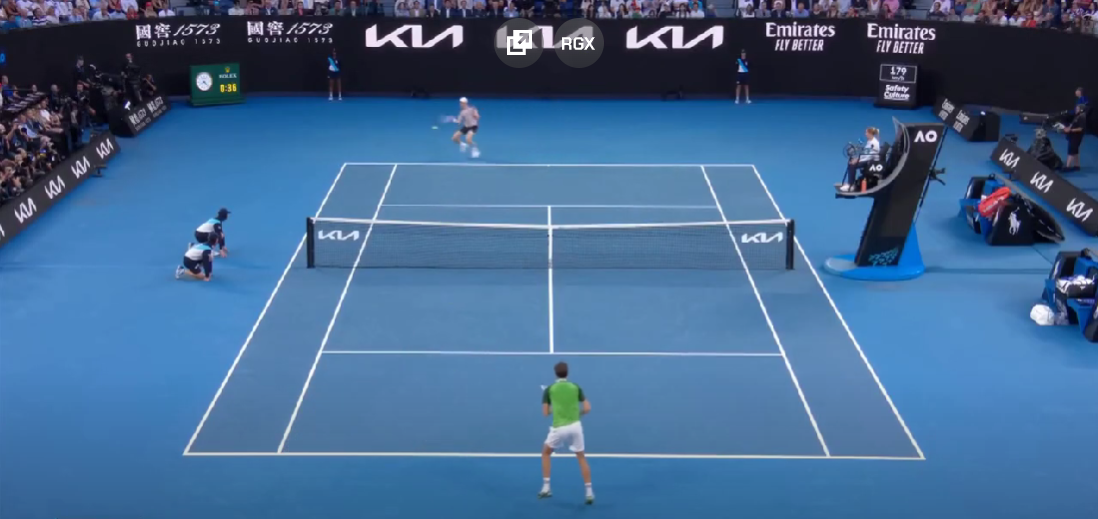

## Frame of the output video with no rectification

* It's possible to see in the video the tennis lines identified alongside with the tracking of th ball


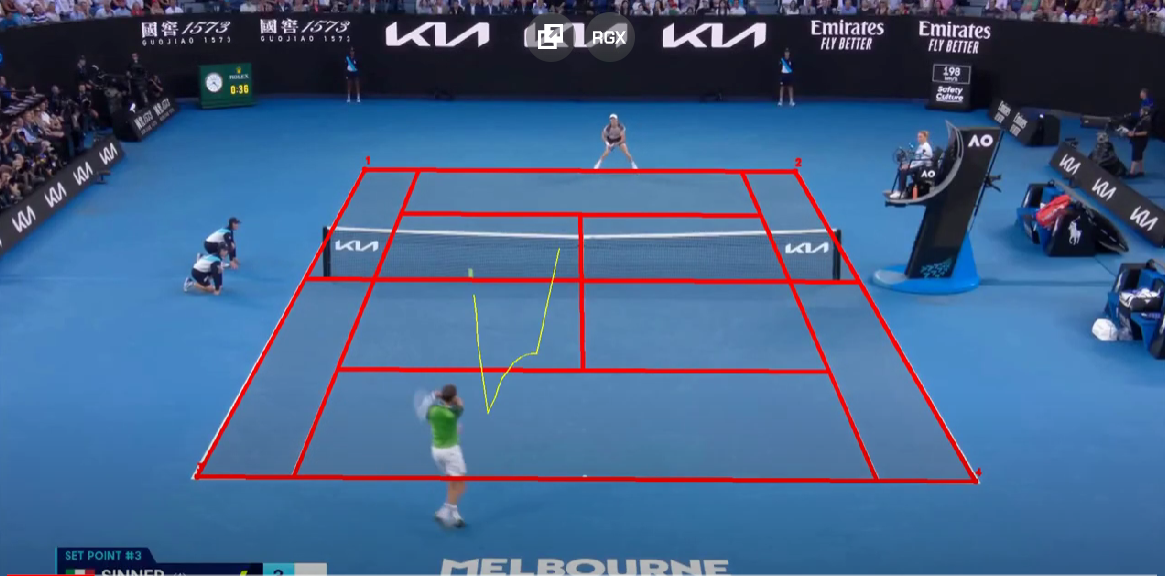

# Trajectory Analysis

Let's plot the trajectory of the ball around the space by the frames and test ways to identify sudden changes in the trajectory (which implies the occurence of a bounce)

In [ ]:
frames_qt = 448
import pickle

# Load the saved coordinates
with open('ball_coords_not_ret_61.pkl', 'rb') as f:
    q = pickle.load(f)
len(q)

447

In [ ]:
q[1]

[1508, 739]

In [ ]:
valid_coords = [q[i] for i in range(len(q)) if q[i] is not None]

x_coords = np.array([valid_coords[i][0] for i in range(len(valid_coords))])
y_coords = np.array([valid_coords[i][1] for i in range(len(valid_coords))])
total_frames_identified = len(valid_coords)

In [ ]:
total_frames_identified/frames_qt

0.6160714285714286

As we can see above, the network has identified the ball on only 61% of the frames, this is considerably low given that the ball is actually present in most of the frames.

### Plotting

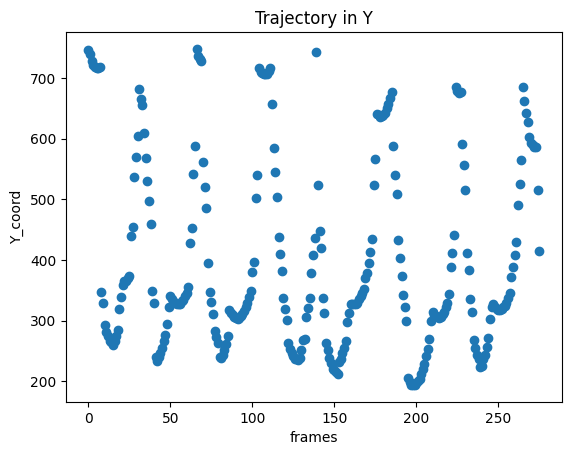

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(list(range(total_frames_identified)), y_coords)
# Labeling axes
plt.xlabel('frames')
plt.ylabel('Y_coord')

plt.title('Trajectory in Y')
plt.show()

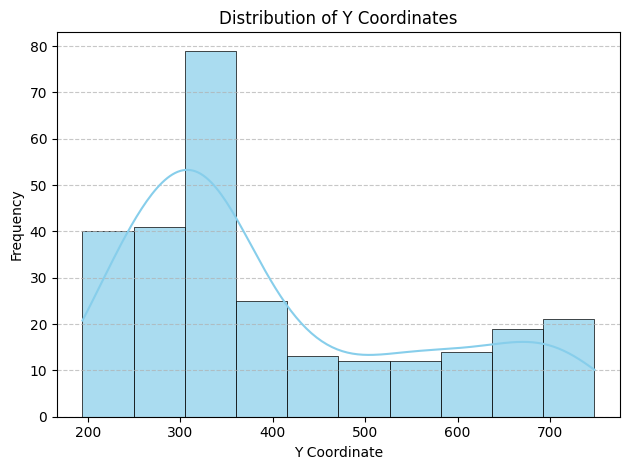

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(y_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('Y Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of Y Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Giving a closer look, its possible to see that the "missing" identifications happen during the flight of the ball from one point to the other, when the ball is fastest. This problem actually does not impair our process, given that during the "fast travels" of the ball, there was not supposed to have a bounce occurence.

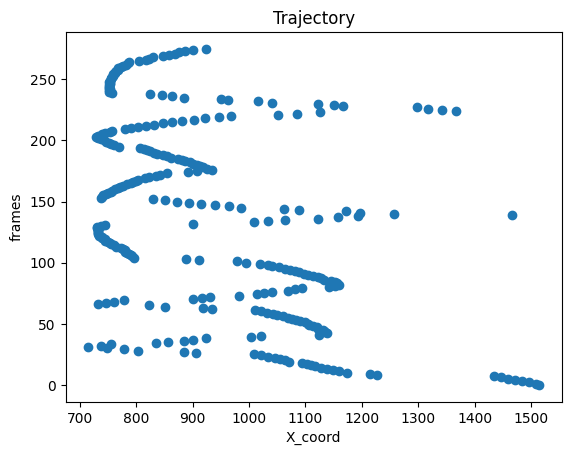

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(x_coords,list(range(total_frames_identified)))
# Labeling axes
plt.ylabel('frames')
plt.xlabel('X_coord')

plt.title('Trajectory')
plt.show()

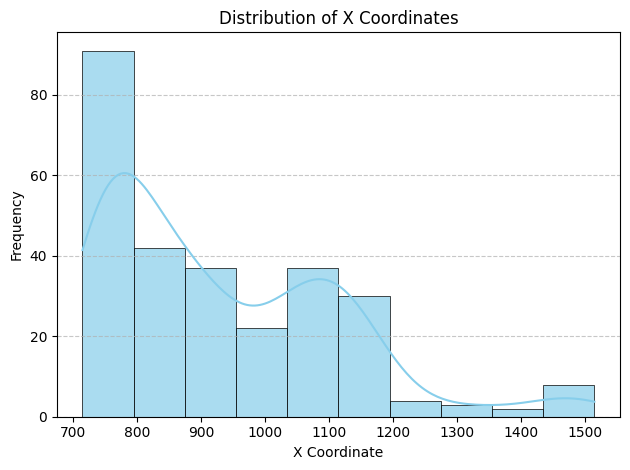

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(x_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of X Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we can see, it's also quite diffcult for the algortihm to identify the ball when it goes further to the right. By looking specifically at the game, its possible to see that most of the game was held in the left side of the field, meaning that this result does make a lot of sense.

# Analysing with the rectification

Now let's see how the results from the tracking algorithm change when the video is rectified first


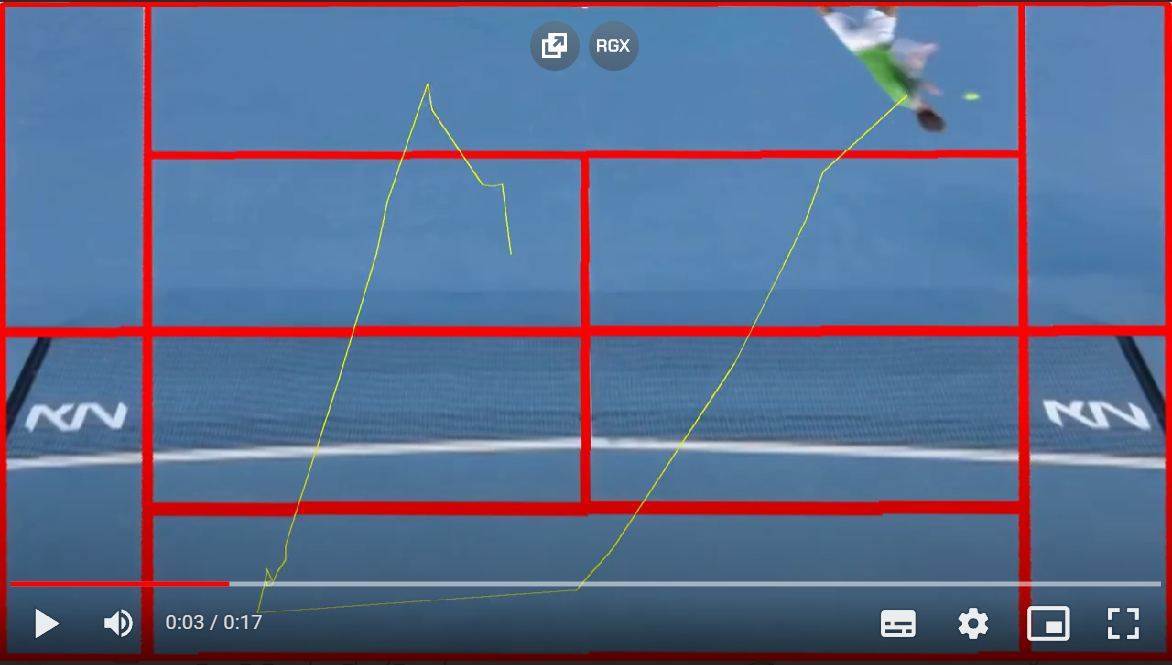

In [ ]:
frames_qt = 448
import pickle

# Load the saved coordinates
with open('ball_coords_with_ret_29.pkl', 'rb') as f:
    q = pickle.load(f)
len(q)

447

In [ ]:
valid_coords = [q[i] for i in range(len(q)) if q[i] is not None]

x_coords = np.array([valid_coords[i][0] for i in range(len(valid_coords))])
y_coords = np.array([valid_coords[i][1] for i in range(len(valid_coords))])
total_frames_identified = len(valid_coords)

In [ ]:
total_frames_identified/frames_qt

0.29910714285714285

Bt looking at these results, its possible to see that the ball tracking performance is even worse wiht the rectified video.

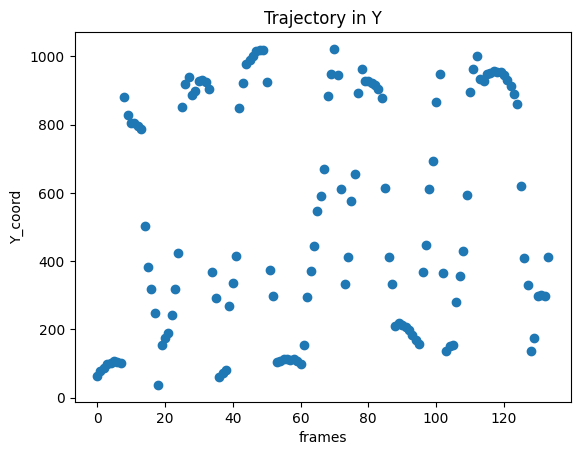

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(list(range(total_frames_identified)), y_coords)
# Labeling axes
plt.xlabel('frames')
plt.ylabel('Y_coord')

plt.title('Trajectory in Y')
plt.show()

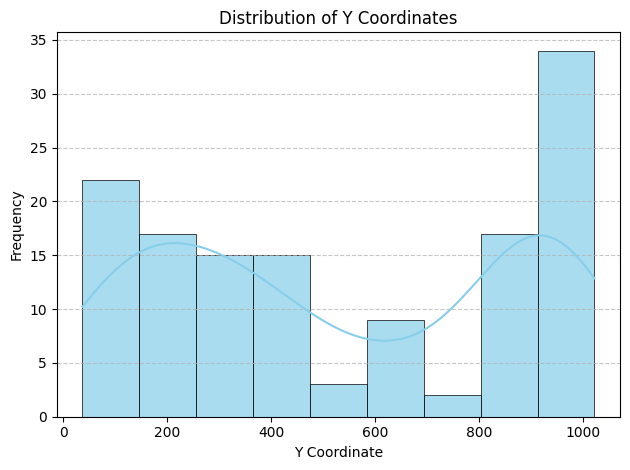

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(y_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('Y Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of Y Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

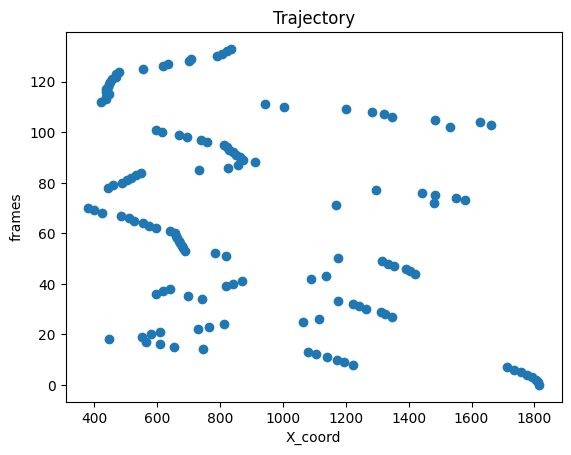

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(x_coords,list(range(total_frames_identified)))
# Labeling axes
plt.ylabel('frames')
plt.xlabel('X_coord')

plt.title('Trajectory')
plt.show()

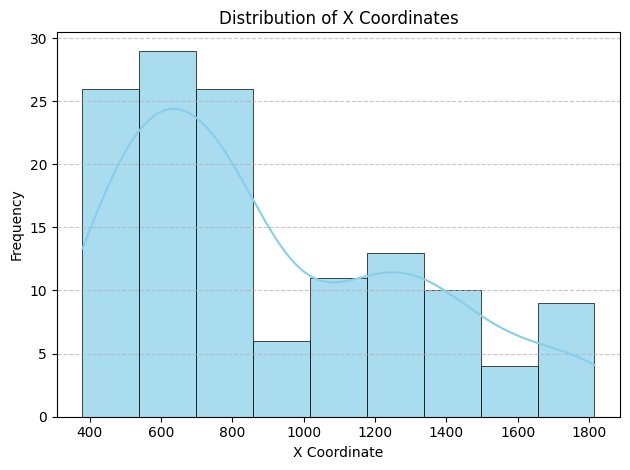

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(x_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of X Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

However, its possible to see that the distribution of the values seem more consistent, which lead us to think that perhaps its possible to try it out

# Analysing with no rectification nor court lines

It's possible to guess that the tracking network may be generating poored results than expected given the presence of the court lines in the video, introduced before the tracking. Given this, let's see how the coordenates behave with no added lines

In [ ]:
frames_qt = 448
import pickle

# Load the saved coordinates
with open('ball_coords_no_court_83.pkl', 'rb') as f:
    q = pickle.load(f)
len(q)

447

In [ ]:
valid_coords = [q[i] for i in range(len(q)) if q[i] is not None]

x_coords = np.array([valid_coords[i][0] for i in range(len(valid_coords))])
y_coords = np.array([valid_coords[i][1] for i in range(len(valid_coords))])
total_frames_identified = len(valid_coords)

In [ ]:
total_frames_identified/frames_qt

0.8325892857142857

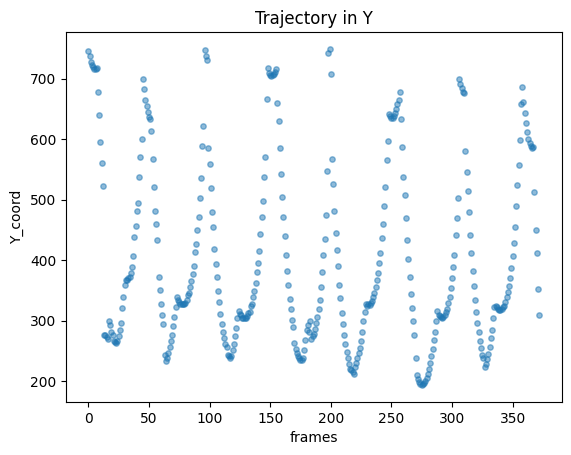

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(list(range(total_frames_identified)), y_coords, s=15, alpha=0.5)
# Labeling axes
plt.xlabel('frames')
plt.ylabel('Y_coord')

plt.title('Trajectory in Y')
plt.show()

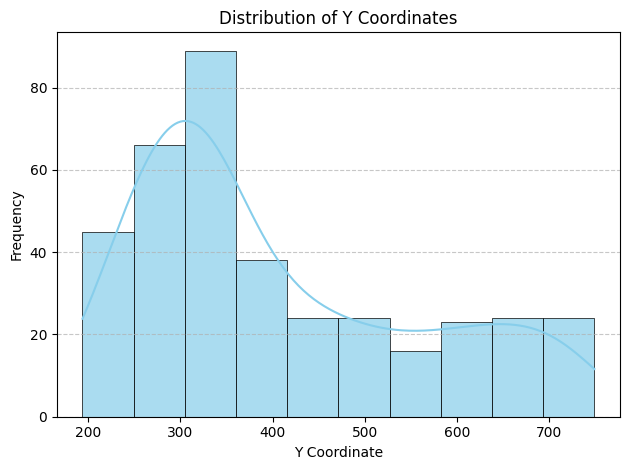

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(y_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('Y Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of Y Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

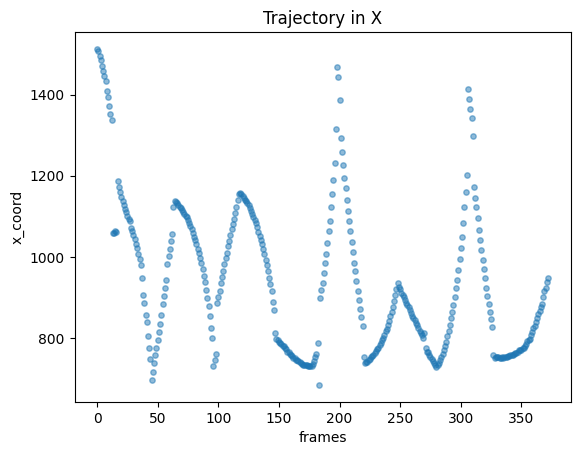

In [ ]:
# Plotting
fig = plt.figure()
plt.scatter(list(range(total_frames_identified)), x_coords, s=15, alpha=0.5)
# Labeling axes
plt.xlabel('frames')
plt.ylabel('x_coord')

plt.title('Trajectory in X')
plt.show()

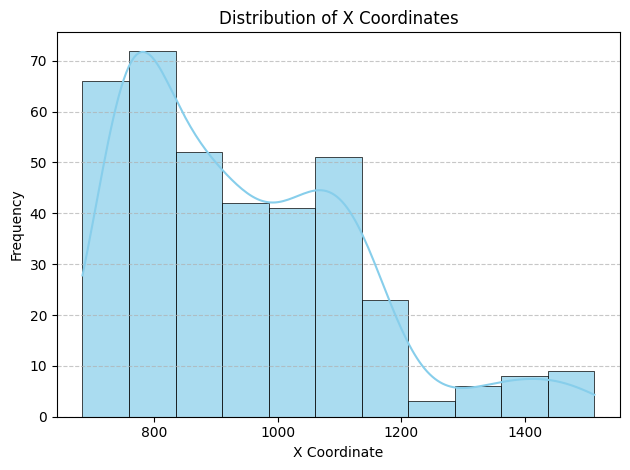

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(x_coords,kde=True,bins='auto',color='skyblue',edgecolor='black', linewidth=0.5, alpha=0.7,)

plt.xlabel('X Coordinate')
plt.ylabel('Frequency')
plt.title('Distribution of X Coordinates')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Conclusions

As we can see, doing the tracking with no added lines make the traking algortihm perform better and, therefore, we will follow the sequence:

* track the ball
* apply a method to identify a bounce
* rectify the court
* obtain the coordinate of the bounce in the rectificated image